In [1]:
import pickle
import warnings

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import (classification_report, f1_score,
                             plot_confusion_matrix, plot_roc_curve,
                             roc_auc_score)
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
features = pd.read_csv('features_train.csv')
classes = pd.read_csv('classes_train.csv')

In [3]:
features.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,5124,6641,3074,13768,126,0,0,1,2711,1.890077,2.449650,1.133899,5.078569,0.046477,2.160377,12,0,14,0,73
1,10672,8465,1575,4561,191,0,1,1,4424,2.412297,1.913427,0.356013,1.030967,0.043174,5.374603,11,0,23,0,142
2,704,3108,454,2400,77,0,0,0,1358,0.518409,2.288660,0.334315,1.767305,0.056701,6.845815,12,0,18,0,90
3,6091,304528,526,599,1515,0,1,1,4214,1.445420,72.265781,0.124822,0.142145,0.359516,578.950570,10,0,11,0,51
4,12967,13693,204,1177,452,0,1,1,3200,4.052187,4.279063,0.063750,0.367812,0.141250,67.122549,13,0,14,0,106


In [4]:
classes.head()

,is_bot
0,0
1,0
2,0
3,0
4,0


In [5]:
df = features.copy()
df['is_bot'] = classes['is_bot']

In [6]:
df.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,...,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length,is_bot
0,5124,6641,3074,13768,126,0,0,1,2711,1.890077,...,1.133899,5.078569,0.046477,2.160377,12,0,14,0,73,0
1,10672,8465,1575,4561,191,0,1,1,4424,2.412297,...,0.356013,1.030967,0.043174,5.374603,11,0,23,0,142,0
2,704,3108,454,2400,77,0,0,0,1358,0.518409,...,0.334315,1.767305,0.056701,6.845815,12,0,18,0,90,0
3,6091,304528,526,599,1515,0,1,1,4214,1.445420,...,0.124822,0.142145,0.359516,578.950570,10,0,11,0,51,0
4,12967,13693,204,1177,452,0,1,1,3200,4.052187,...,0.063750,0.367812,0.141250,67.122549,13,0,14,0,106,0


In [7]:
df.shape

(2400, 21)

In [8]:
df.describe()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,...,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length,is_bot
count,2.400000e+03,2.400000e+03,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2.400000e+03,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,2.629046e+04,8.955198e+04,1963.246250,10648.327917,709.082083,0.243333,0.704167,0.743750,3382.837083,7.634789,...,0.497441,2.810923,0.169272,3.284046e+03,11.179583,0.118750,13.923750,0.059167,111.012917,0.250000
std,5.771702e+04,7.347846e+05,6095.658137,24481.941917,3343.528520,0.429184,0.456512,0.436652,1234.070943,20.714654,...,1.451790,6.764467,0.693192,3.140602e+04,2.634747,0.513736,4.789136,0.395682,43.193461,0.433103
min,8.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,726.000000,0.001752,...,0.000000,0.000000,0.000000,6.859206e-02,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,4.531000e+03,1.528250e+03,110.000000,90.000000,43.000000,0.000000,0.000000,0.000000,2220.250000,1.537573,...,0.033929,0.034419,0.014677,3.310664e+00,9.000000,0.000000,11.000000,0.000000,79.000000,0.000000
50%,1.141750e+04,6.512500e+03,881.500000,2728.500000,158.000000,0.000000,1.000000,1.000000,3834.500000,3.536165,...,0.224359,0.734363,0.043637,1.200000e+01,11.000000,0.000000,13.000000,0.000000,123.000000,0.000000
75%,2.758800e+04,2.634400e+04,1969.000000,10688.250000,480.000000,0.000000,1.000000,1.000000,4396.000000,7.838287,...,0.502255,2.659280,0.119837,8.490969e+01,13.000000,0.000000,16.000000,0.000000,149.000000,0.250000
max,1.768111e+06,1.848919e+07,128736.000000,462740.000000,112295.000000,1.000000,1.000000,1.000000,5388.000000,708.661723,...,27.378988,121.517857,21.906945,1.342549e+06,15.000000,8.000000,48.000000,8.000000,172.000000,1.000000


In [9]:
df.isnull().sum()

statuses_count                     0
followers_count                    0
friends_count                      0
favourites_count                   0
listed_count                       0
is_default_profile                 0
is_profile_use_background_image    0
is_verified                        0
user_age                           0
tweets_freq                        0
followers_growth_rate              0
friends_growth_rate                0
favourites_growth_rate             0
listed_growth_rate                 0
followers_friends_ratio            0
screen_name_length                 0
num_digits_in_screen_name          0
length_of_name                     0
num_digits_in_name                 0
description_length                 0
is_bot                             0
dtype: int64

In [10]:
X, y = df.drop('is_bot', axis=1), df['is_bot']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, shuffle=True)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 20), (1200, 20), (1200,), (1200,))

### 1. Базовый контекст (делают все хоть как-то)

1.1 Обучить модель без каких-либо дополнительных условий, которая должна наилучшим образом отработать на тестовой выборке преподавателя с точки зрения F-меры

In [13]:
model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)
model_pred = model.predict(X_test)
print(f"F1: {f1_score(y_test, model_pred) * 100:.5f}%")

F1: 99.32203%


In [14]:
with open('model.pkl','wb') as f:
    pickle.dump(model, f)

## 2. Вторичные контесты

2.1. Максимально логичным образом обучить качественную модель, использующую для работы только 10 признаков из всего исходного множества.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

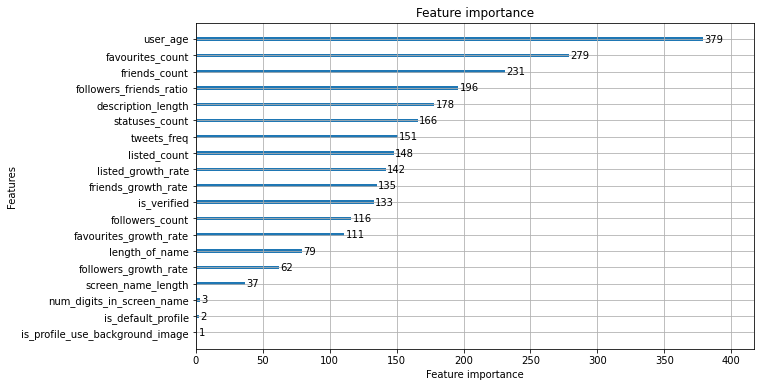

In [15]:
lgbm.plot_importance(model)

In [16]:
df_new = df[[
    'user_age',
    'favourites_count',
    'friends_count',
    'followers_friends_ratio',
    'description_length',
    'statuses_count',
    'tweets_freq',
    'listed_count',
    'listed_growth_rate',
    'friends_growth_rate',
    'is_bot'
]]

In [17]:
X_new, y_new = df_new.drop('is_bot', axis=1), df_new['is_bot']

In [18]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.5, random_state=1, shuffle=True)

In [19]:
model_new = lgbm.LGBMClassifier()
model_new.fit(X_train_new, y_train_new)
model_pred_new = model_new.predict(X_test_new)
print(f"F1: {f1_score(y_test_new, model_pred_new) * 100:.5f}%")

F1: 97.10392%


2.2. Обучить модель, обеспечивающую вероятность пропуска бота на уровне не выше 0.03, и имеющую насколько возможно низкую вероятность ложного обнаружения.

In [20]:
model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)
model_pred = model.predict(X_test)
print(f"F1: {f1_score(y_test, model_pred) * 100:.5f}%")

F1: 99.32203%


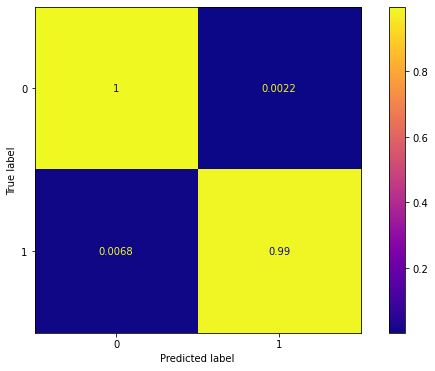

In [21]:
plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap='plasma')

### 3. Углубленное аналитическое исследование по имеющимся данным

3.1. Тем или иным способом выполнить сравнительное исследование значимости различных
признаков применительно к произвольному фиксированному классификатору.

In [22]:
boost = model.booster_

df_feature_importance = (
    pd.DataFrame({
        'feature': boost.feature_name(),
        'importance': boost.feature_importance(),
    })
    .sort_values('importance', ascending=False)
).reset_index().drop('index', axis=1)

df_feature_importance

,feature,importance
0,user_age,379
1,favourites_count,279
2,friends_count,231
3,followers_friends_ratio,196
4,description_length,178
5,statuses_count,166
6,tweets_freq,151
7,listed_count,148
8,listed_growth_rate,142
9,friends_growth_rate,135


3.2. Синтезировать 3 или более собственных признаков на основе имеющихся и показать, что
они имеют какие-либо преимущества перед хотя бы какими либо из базовых признаков.

3.3. Выбрать один базовый тип ML-модели на свой вкус (SVM, дерево решений, случайный
лес, градиентный бустинг и пр.) и провести ROC-анализ в зависимости от её
гиперпараметров.

In [23]:
learning_rate = np.arange(0.1, 3.1, 0.1)
n_estimators = np.arange(101, 201, 1)

  0%|          | 0/30 [00:00<?, ?it/s]

<AxesSubplot:xlabel='learning_rate', ylabel='roc_auc'>

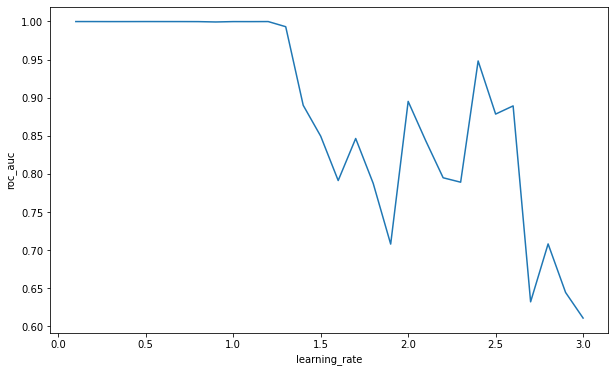

In [24]:
lgbm_learning_rate = []

for learn_rate in tqdm(learning_rate):
    model = lgbm.LGBMClassifier(learning_rate=learn_rate)
    lgbm_learning_rate.append(np.mean(cross_val_score(model, X, y, scoring="roc_auc")))
    
learn_rate_df = pd.DataFrame(data={"learning_rate": learning_rate, "roc_auc": lgbm_learning_rate})
sns.lineplot(data=learn_rate_df, x="learning_rate", y="roc_auc")

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:xlabel='n_estimators', ylabel='roc_auc'>

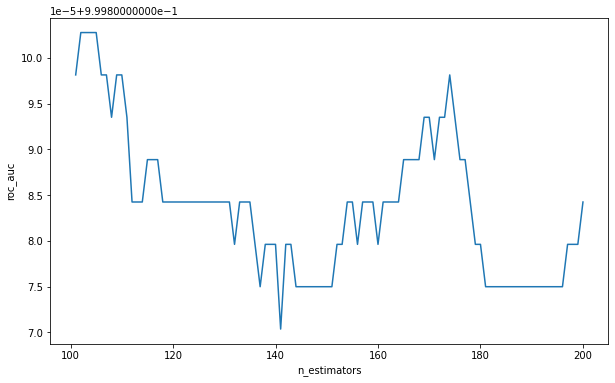

In [25]:
lgbm_estimators = []

for estim in tqdm(n_estimators):
    model = lgbm.LGBMClassifier(n_estimators=estim)
    lgbm_estimators.append(np.mean(cross_val_score(model, X, y, scoring="roc_auc")))
    
estim_df = pd.DataFrame(data={"n_estimators": n_estimators, "roc_auc": lgbm_estimators})
sns.lineplot(data=estim_df, x="n_estimators", y="roc_auc")

3.4 Провести исследование влияние параметров обучения на недо- и переобученность
модели.

  0%|          | 0/30 [00:00<?, ?it/s]

<AxesSubplot:xlabel='learning_rate', ylabel='roc_auc'>

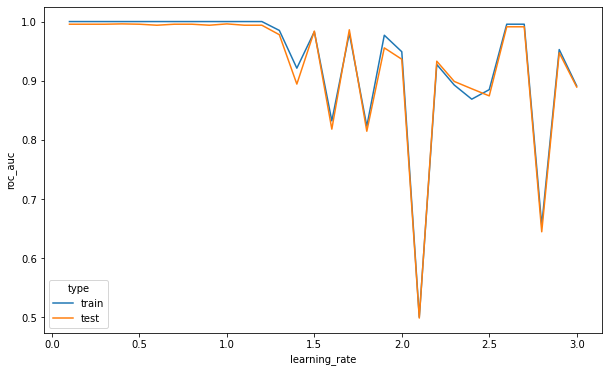

In [26]:
lgbm_lr = []

for i in tqdm(learning_rate):
    model = lgbm.LGBMClassifier(learning_rate=i)
    model.fit(X_train, y_train)

    train_roc_auc = roc_auc_score(y_train, model.predict(X_train))
    lgbm_lr.append({"learning_rate": i, "roc_auc": train_roc_auc, "type": "train"})

    test_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    lgbm_lr.append({"learning_rate": i, "roc_auc": test_roc_auc, "type": "test"})
    
lgbm_lr_df = pd.DataFrame(lgbm_lr)
sns.lineplot(data=lgbm_lr_df, x="learning_rate", y="roc_auc", hue="type")

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:xlabel='n_estimators', ylabel='roc_auc'>

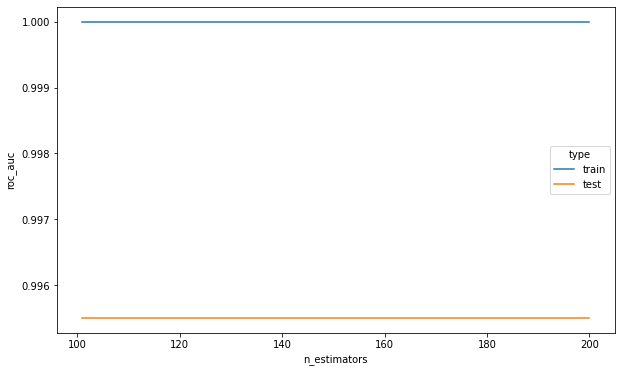

In [27]:
lgbm_estim = []

for i in tqdm(n_estimators):
    model = lgbm.LGBMClassifier(n_estimators=estim)
    model.fit(X_train, y_train)

    train_roc_auc = roc_auc_score(y_train, model.predict(X_train))
    lgbm_estim.append({"n_estimators": i, "roc_auc": train_roc_auc, "type": "train"})

    test_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    lgbm_estim.append({"n_estimators": i, "roc_auc": test_roc_auc, "type": "test"})
    
    
estim_df = pd.DataFrame(lgbm_estim)
sns.lineplot(data=estim_df, x="n_estimators", y="roc_auc", hue='type')